In [ ]:
pip install keras-vggface

In [ ]:
pip install Keras-Applications

     |████████████████████████████████| 51kB 7.1MB/s 


In [ ]:
#Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from keras_vggface.vggface import VGGFace
import skimage
from skimage.transform import rescale, resize

In [ ]:
vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(197, 197, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = layers.Flatten(name='flatten')(last_layer)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4096, activation='relu', name='fc6')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu', name='fc7')(x)
x = layers.Dropout(0.5)(x)

In [ ]:
batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
for i in range(170):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False

In [ ]:
out = layers.Dense(7, activation='softmax', name='classifier')(x)

model = models.Model(vgg_notop.input, out)

In [ ]:
#sgd = keras.optimizers.SGD(lr=0.01, momentum=0.5, decay=0.0001, nesterov=True)
sgd = keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
rlrop = ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=7, min_lr=0.00001, verbose=1)
callback = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max', restore_best_weights=True)

In [ ]:
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(197, 197),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=128)

In [ ]:
! rm -rf train; mkdir train
! unzip -q /content/drive/MyDrive/train.zip -d train
! rm -rf dev; mkdir dev
! unzip -q /content/drive/MyDrive/test-public.zip -d dev
! rm -rf test; mkdir test
! unzip -q /content/drive/MyDrive/test-private.zip -d test

In [ ]:
train_generator  = get_datagen('/content/train', True)
dev_generator    = get_datagen('/content/dev')
test_generator  = get_datagen('/content/test')

Found 8709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
%%bash
root='train/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

0 angry: 1192
1 disgust: 112
2 fear: 1181
3 happy: 2207
4 sad: 1473
5 surprise: 1039
6 neutral: 1505


In [ ]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=8709// 128,
    validation_steps=3509 // 128,
    shuffle=True,
    epochs=150,
    callbacks=[rlrop]
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
68/68 [==============================] - 96s 1s/step - loss: 1.5133 - accuracy: 0.3530 - val_loss: 1.4836 - val_accuracy: 0.3932
Epoch 2/150
68/68 [==============================] - 93s 1s/step - loss: 1.4944 - accuracy: 0.3778 - val_loss: 1.4682 - val_accuracy: 0.3854
Epoch 3/150
68/68 [==============================] - 93s 1s/step - loss: 1.4670 - accuracy: 0.3769 - val_loss: 1.4841 - val_accuracy: 0.3903
Epoch 4/150
68/68 [==============================] - 93s 1s/step - loss: 1.4529 - accuracy: 0.3803 - val_loss: 1.4786 - val_accuracy: 0.3921
Epoch 5/150
68/68 [==============================] - 93s 1s/step - loss: 1.4612 - accuracy: 0.3812 - val_loss: 1.4933 - val_accuracy: 0.3880
Epoch 6/150
68/68 [==============================] - 93s 1s/step - loss: 1.4484 - accuracy: 0.3902 - val_loss: 1.4699 - val_accuracy: 0.3921
Epoch 7/150
68/68 [==============================] - 93s 1s/step - loss: 1.4358 - accuracy: 0.3835 - val_loss: 1.4616 - val_accuracy: 0.3976
Epoch 8/150
6

In [ ]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 3509 // 128)
print('test loss, test acc:', results_test)


# Evaluate on test data


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test loss, test acc: [1.0072736740112305, 0.6542245149612427]


In [ ]:
model.save('/content/drive/My Drive/resnet50-vggface-v2-65.h5')

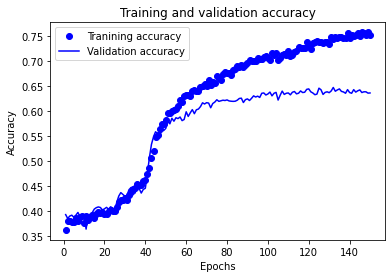

In [ ]:
#Plot accuracy
def plot_acc():
    
    plt.clf()

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']


    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, 'bo', label='Tranining accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
plot_acc()

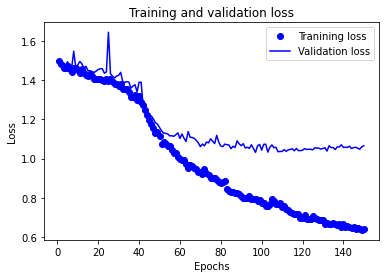

In [ ]:
#Plot loss
def plot_loss():
    
    plt.clf()
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    plt.plot(epochs, loss, 'bo', label='Tranining loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_loss()